In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.pyplot import rcParams
import csv
import cv2

class treeNode():
    def __init__(self, locationX, locationY):
        self.locationX = locationX                #X Location
        self.locationY = locationY                #Y Location  
        self.children = []                        #children list   
        self.parent = None                        #parent node reference 
        
#RRT Star Algorithm class
class RRTStarAlgorithm():
    def __init__(self, start, goal, numIterations, grid, stepSize, image_number):
        self.randomTree = treeNode(start[0], start[1])          #The RRT (root position) (has 0 cost)
        self.goal = treeNode(goal[0], goal[1])                  #goal position (initialize to a high cost)
        self.nearestNode = None                                 #nearest node            
        self.iterations = min(numIterations, 700)               #number of iterations to run
        self.grid = grid                                        #the map
        self.rho = stepSize                                     #length of each branch   
        self.nearestDist = 10000                                #distance to nearest node (initialize with large)
        self.numWaypoints = 0                                   #number of waypoints
        self.Waypoints = []                                     #the waypoints
        self.searchRadius = self.rho*2                          #the radius to search for finding neighbouring vertices 
        self.neighbouringNodes = []                             #neighbouring nodes  
        self.goalArray = np.array([goal[0],goal[1]])            #goal as an array
        self.goalCosts = [10000]                                #the costs to the goal (ignore first value)
        self.image_number = image_number
        
        
        
            
    #add the node to the nearest node, and add goal if necessary (TODO--------)     
    def addChild(self, treeNode):
        if (treeNode.locationX == self.goal.locationX):
            #append goal to nearestNode's children
            self.nearestNode.children.append(self.goal)
            #and set goal's parent to nearestNode
            self.goal.parent = self.nearestNode
        else:    
            #append this node to nearestNode's children
            self.nearestNode.children.append(treeNode)
            #set the parent to nearestNode
            treeNode.parent = self.nearestNode
        
    #sample random point within grid limits (DONE)
    def sampleAPoint(self):
        x = random.randint(1, grid.shape[1])
        y = random.randint(1, grid.shape[0])
        point = np.array([x, y])
        return point
    
    #steer a distance stepSize from start location to end location (keep in mind the grid limits) (DONE)
    def steerToPoint(self, locationStart, locationEnd):
        offset = self.rho*self.unitVector(locationStart, locationEnd)
        point = np.array([locationStart.locationX + offset[0], locationStart.locationY + offset[1]])
        if point[0] >= grid.shape[1]:
            point[0] = grid.shape[1]-1
        if point[1] >= grid.shape[0]:
            point[1] = grid.shape[0]-1
        return point
    
    #check if obstacle lies between the start and end point of the edge (DONE)
    def isInObstacle(self, locationStart, locationEnd):
        u_hat = self.unitVector(locationStart, locationEnd)
        testPoint = np.array([0.0, 0.0])
        dist = self.distance(locationStart, locationEnd)
        # Check if dist is NaN
        if np.isnan(dist):
            return False
        for i in range(int(dist)):
            testPoint[0] = min(grid.shape[1]-1, locationStart.locationX + i*u_hat[0])
            testPoint[1] = min(grid.shape[0]-1,locationStart.locationY + i*u_hat[1])
            if self.grid[round(testPoint[1]),round(testPoint[0])] == 0:
                return True
        return False

    #find the unit vector between 2 locations (DONE)
    def unitVector(self, locationStart, locationEnd):
        v = np.array([locationEnd[0] - locationStart.locationX, locationEnd[1] - locationStart.locationY])
        u_hat = v/np.linalg.norm(v)
        return u_hat
    
    #find the nearest node from a given (unconnected) point (Euclidean distance) (TODO--------)  
    def findNearest(self, root, point):
        if not root:
            return
        #find distance between root and point use distance method,
        distance_to_nearest = self.distance(root, point)
        #if it's lower than or equal to nearestDist then
        if distance_to_nearest <= self.nearestDist:
            #update nearestNode to root
            self.nearestNode = root
            #update nearestDist to the distance from line 84
            self.nearestDist = distance_to_nearest
        #recursive call
        for child in root.children:
            self.findNearest(child, point)
            
    #find neighbouring nodes (TODO--------)         
    def findNeighbouringNodes(self,root,point):
        if not root:
            return
        #find distance between root and point (dist)
        distance_root_point = self.distance(root, point)
        #add root to neighbouringNodes if dist is less than or equal to searchRadius
        if distance_root_point <= self.searchRadius:
            self.neighbouringNodes.append(root)
        #recursive call
        for child in root.children:
            self.findNeighbouringNodes(child, point)        

    #find euclidean distance between a node and an XY point (DONE)
    def distance(self, node1, point):
        dist = np.sqrt((node1.locationX - point[0])**2 + (node1.locationY - point[1])**2)         
        return dist
    
    #check if the goal is within stepsize (rho) distance from point, return true if so otherwise false (TODO--------)
    def goalFound(self,point):
        if self.distance(self.goal, point) <= self.rho:
            return True
        return False
            
    #reset: set nearestNode to None, nearestDistance to 10K and neighbouringNodes to empty array
    def resetNearestValues(self):
        self.nearestNode = None
        self.nearestDist = 10000
        self.neighbouringNodes = []
    
    #trace the path from goal to start, since have to reset if called many times, do this iteratively (TODO--------)
    def retracePath(self):
        self.numWaypoints = 0
        self.Waypoints = []
        goalCost = 0
        goal = self.goal
        while goal.locationX != self.randomTree.locationX:
            self.numWaypoints += 1
            # goal = np.array([goal.locationX, goal.locationY])
            self.Waypoints.insert(0, np.array([goal.locationX, goal.locationY]))
            goalCost += self.distance(goal.parent, np.array([goal.locationX, goal.locationY]))
            goal = goal.parent  #set the node to it's parent
        self.goalCosts.append(goalCost)    
        output_file = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\output2.csv"

        with open(output_file, 'a', newline='') as file:
            writer = csv.writer(file)
            if file.tell() == 0: # Checks if the file is empty
                writer.writerow(['current_x', 'current_y', 'index_start', 'index_goal', 'image_number'])
            index_start = self.row_number 
            index_goal = index_start + len(rrtStar.Waypoints) - 2
            for i in range(len(rrtStar.Waypoints)-1):
                current_x, current_y = rrtStar.Waypoints[i][0], rrtStar.Waypoints[i][1]
                if i == 0:
                    writer.writerow([start_x, start_y, index_start, index_goal, image_number])
                elif i == len(rrtStar.Waypoints)-2:
                    writer.writerow([goal_x, goal_y])
                else:
                    writer.writerow([current_x, current_y])
                self.row_number += 1
        return self.row_number

    #find unique path length from root of a node (cost) (DONE)
    def findPathDistance(self, node):
        costFromRoot = 0
        currentNode = node 
        while currentNode and currentNode.parent and currentNode.locationX != self.randomTree.locationX:
                parent_location = np.array([currentNode.parent.locationX, currentNode.parent.locationY])
                costFromRoot += self.distance(currentNode, parent_location)
                currentNode = currentNode.parent   
                if currentNode is None or currentNode.parent is None:
                    return 0
        return costFromRoot


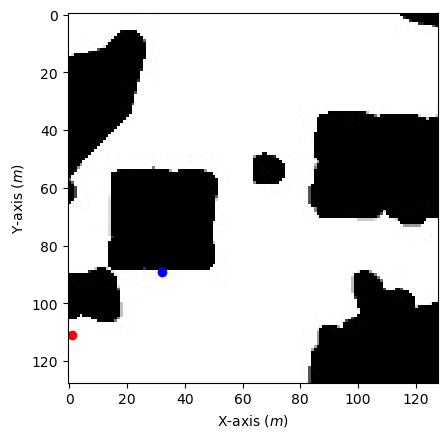

AttributeError: 'RRTStarAlgorithm' object has no attribute 'row_number'

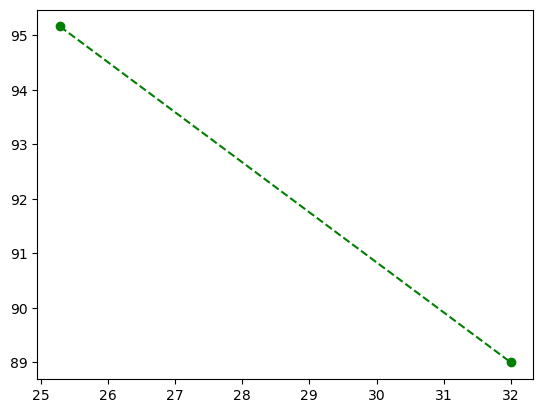

In [7]:
file_path = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\data_amend\new_points.csv"

while True:
            start_x, start_y, goal_x, goal_y, image_number = 1, 111, 32, 89, 0
            image_path = cv2.imread(f'/home/sj/Deep-RRT-Star-Implementation/images/{image_number}.jpg')

            grid = cv2.cvtColor(image_path, cv2.COLOR_BGR2GRAY) 

            # Display the image
            fig = plt.figure("RRT Star Algorithm")
            numIterations = 700
            stepSize = 5

            plt.imshow(grid , cmap = 'gray')
            plt.plot(start_x,start_y,'ro')
            plt.plot(goal_x,goal_y,'bo')
            ax = fig.gca()
            # ax.add_patch(goalRegion)
            plt.xlabel('X-axis $(m)$')
            plt.ylabel('Y-axis $(m)$')

            start = np.array([start_x, start_y])
            goal = np.array([goal_x, goal_y])
                
            #Begin
            rrtStar = RRTStarAlgorithm(start, goal, numIterations, grid, stepSize, image_number)
            plt.pause(2)

            #RRT Star algorithm (TODO-------)
            #iterate
            for i in range(rrtStar.iterations):
                #Reset nearest values, call the resetNearestValues method
                rrtStar.resetNearestValues()
                # print("Iteration: ",i)
                
                #algorithm begins here-------------------------------------------------------------------------------
                
                #sample a point (use the appropriate method)
                point = rrtStar.sampleAPoint()
                #find the nearest node w.r.t to the point (just call the method do not return anything)
                rrtStar.findNearest(rrtStar.randomTree, point)
                new = rrtStar.steerToPoint(rrtStar.nearestNode, point)
                #if not in obstacle    
                if not rrtStar.isInObstacle(rrtStar.nearestNode, new):
                    rrtStar.findNeighbouringNodes(rrtStar.randomTree, new)
                    min_cost_node = rrtStar.nearestNode
                    min_cost = rrtStar.findPathDistance(min_cost_node)
                    min_cost = min_cost + rrtStar.distance(rrtStar.nearestNode, new)
                    
                    #for each node in neighbouringNodes
                    for vertex in rrtStar.neighbouringNodes:
                        #find the cost from the root (findPathDistance)
                        min_cost_with_neighbor = rrtStar.findPathDistance(vertex)
                        #add the distance between the node and the new point ('new') to the above cost (use the relevant method)
                        min_cost_with_neighbor += rrtStar.distance(vertex, new)
                        #if node and new are obstacle free AND the cost is lower than min_cost (use the relevant method)
                        if not rrtStar.isInObstacle(vertex, new) and min_cost_with_neighbor < min_cost:
                            #set the min_cost_node to this node
                            min_cost_node = vertex
                            #set the min_cost to this cost
                            min_cost = min_cost_with_neighbor

                    #update nearest node to min_cost_node, create a treeNode object from the new point - call this newNode ('new[0],new[1]')
                    rrtStar.nearestNode = min_cost_node
                    newNode = treeNode(new[0], new[1])
                    #SIDE NOTE: if neighbouringNodes is empty, it'll add to the original nearest node (obstacle free)  
                    #addChild (add newNode to the nearest node - which is now updated and is the minimum cost node)
                    rrtStar.addChild(newNode)
                    #plot for display
                    # plt.pause(0.01)
                    # plt.plot([rrtStar.nearestNode.locationX, new[0]], [rrtStar.nearestNode.locationY, new[1]],'go', linestyle="--")  
                    
                    #rewire tree (TODO-------)    
                    #for each node in neighbouringNodes
                    for vertex in rrtStar.neighbouringNodes:
                        #set a variable: 'cost' to min_cost
                        cost = min_cost
                        #add the distance between 'new' and node to cost
                        cost += rrtStar.distance(vertex, new)
                        #if node and new are obstacle free AND the cost is lower than the distance from root to vertex (use findPathDistance method)
                        if rrtStar.isInObstacle(vertex, new) and cost < rrtStar.findPathDistance(vertex):
                            vertex.parent = newNode
                        #set the parent of node to 'newNode' (see line 190)
                        
                    #if goal found, and the projected cost is lower, then append to path let it sample more (DONE)
                    point = np.array([newNode.locationX, newNode.locationY])
                    if rrtStar.goalFound(point):
                        projectedCost = rrtStar.findPathDistance(newNode) + rrtStar.distance(rrtStar.goal, point)
                        if projectedCost > 0 :
                            if projectedCost < rrtStar.goalCosts[-1]:
                                rrtStar.addChild(rrtStar.goal)
                                plt.plot([rrtStar.nearestNode.locationX, rrtStar.goalArray[0]], [rrtStar.nearestNode.locationY, rrtStar.goalArray[1]],'go', linestyle="--") 
                                # retrace and plot, this method finds waypoints and cost from root
                                row_number = rrtStar.retracePath()
                                r_n = row_number
                                print("Goal Cost: ", rrtStar.goalCosts)
                                plt.pause(0.25)
                                rrtStar.Waypoints.insert(0,start)
                                for i in range(len(rrtStar.Waypoints)-1):
                                        print("Waypoint: ", rrtStar.Waypoints[i][0], rrtStar.Waypoints[i][1])
                                        plt.plot([rrtStar.Waypoints[i][0], rrtStar.Waypoints[i+1][0]], [rrtStar.Waypoints[i][1], rrtStar.Waypoints[i+1][1]],'ro', linestyle="--")
                                        plt.pause(0.01)
                                break

In [6]:
print(start_row_number)

267
